In [2]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


# metrics evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# To standardise data
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
#from imblearn.under_sampling import RandomUnderSampler

# For train/test split
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold as vt
#from imblearn.pipeline import make_pipeline, Pipeline
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [3]:
#import CSVs, assign headers and remove quotations from column headers
red_wine = pd.read_csv(r'C:\Users\Killian\Projects\Wine analysis\Wine data\winequality-red.csv', sep=';',header=0, engine='python')

In [4]:
red_wine['label'] = red_wine['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <=6 else 'high')
red_wine.head()
red_wine["label"].value_counts()

low       744
medium    638
high      217
Name: label, dtype: int64

In [5]:
features=red_wine.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [6]:
#red_label = LabelEncoder()
red_wine['category'] = red_wine.label.map({"low" : "0", "medium" : "1", "high" : "2"}).astype('int')
red_wine= red_wine.drop(columns="quality")
print(red_wine.category.value_counts())
red_wine.category.dtypes
#As seen from previous results, Medium = 2, Low = 1, High = 0.
#Can't use OrdinalEncoder as it is 1D data. Ordinal Encoder is used on 2D array. 

0    744
1    638
2    217
Name: category, dtype: int64


dtype('int32')

In [7]:
red_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label,category
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,low,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,medium,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,medium,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,low,0
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,medium,1


In [8]:
#Create target and features for algorithm
#Full feature list for ease of access while doing Backward Eliination and refining model: 'fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 
# 'sulphates','citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'
X = red_wine.copy()
y = X.category #target
X =red_wine.drop(columns=['category', 'label', 'citric acid', 'total sulfur dioxide', 'density', 'pH']) # features we want to test, except target and correlated values, i.e. Quality and Label. 
# Final list will include features removed due to results from Backward Elimination.
X_list = list(X.columns)
print(X.columns.tolist())
print(y)

['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol']
0       0
1       0
2       0
3       1
4       0
       ..
1594    0
1595    1
1596    1
1597    0
1598    1
Name: category, Length: 1599, dtype: int32


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #, stratify=y) # random state controls the shuffling applied before the split. 42 is a popular random seed.
#stratification ensures equitable split of low/medium/high quality across training and test data
print(Counter(y_train), Counter(y_test))
print('Features:', list(X))

Counter({0: 531, 1: 438, 2: 150}) Counter({0: 213, 1: 200, 2: 67})
Features: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol']


In [10]:
# Because of the skewedness of the model, with many outliers, it does not seem appropriate to use either normalisation or
# standardisation. I will be applying a tree based algorithm which is insensitive to the scale of features as it splits
# nodes based on single features. 

#Below I am testing to make sure the shapes are as predicted (column numbers match)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1119, 7)
Training Labels Shape: (1119,)
Testing Features Shape: (480, 7)
Testing Labels Shape: (480,)


In [11]:
# fit model to training data (firstly uing defaults)
model = XGBC(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
print(model) #See the parameters used 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)


In [12]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.96%


In [13]:
#Poor agreement = Less than 0.20 (including negative numbers)
#Fair agreement = 0.20 to 0.40
#Moderate agreement = 0.40 to 0.60
#Good agreement = 0.60 to 0.80
#Very good agreement = 0.80 to 1.00

# Cohen’s Kappa is a statistical measure that is used to measure the reliability of 
# two raters who are rating the same quantity and identifies how frequently the raters are in agreement. 


kappa = cohen_kappa_score(y_pred, y_test)
print("Cohen-Kappa score:", round(kappa, 2))

Cohen-Kappa score: 0.49


In [14]:
print(classification_report(y_test, y_pred, target_names=["low","medium", "high"]))

              precision    recall  f1-score   support

         low       0.72      0.80      0.76       213
      medium       0.66      0.60      0.63       200
        high       0.65      0.58      0.61        67

    accuracy                           0.69       480
   macro avg       0.68      0.66      0.67       480
weighted avg       0.69      0.69      0.69       480



In [15]:
print("Confusion matrix:")
labels = np.unique(y_test)
a = confusion_matrix(y_test, y_pred, labels=labels)
a = pd.DataFrame(a, index=("low", "medium", "high"), columns=("low", "medium", "high"))
display(a)

Confusion matrix:


,low,medium,high
low,171,40,2
medium,60,121,19
high,6,22,39


In [16]:
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
print(cross_val_score(model, X, y, cv=3))

[0.55909944 0.59849906 0.57973734]


In [17]:
#show feature importance

for i in zip(X_list, model.feature_importances_):
    print (i)

('fixed acidity', 0.112208836)
('volatile acidity', 0.13253255)
('residual sugar', 0.10567779)
('chlorides', 0.101729326)
('free sulfur dioxide', 0.11686908)
('sulphates', 0.15799457)
('alcohol', 0.27298787)


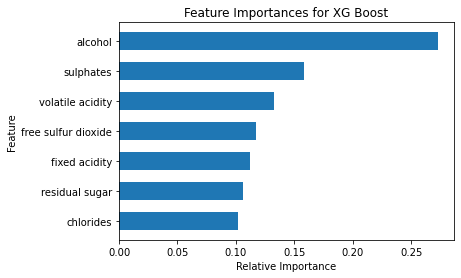

In [18]:
importances = model.feature_importances_
model_feature_names, model_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'residual sugar','chlorides', 'free sulfur dioxide', 'sulphates', 'alcohol'],
importances), key=lambda x: x[1]))
y_position = list(range(len(model_feature_names)))
plt.barh(y_position, model_feature_scores, height=0.6, align='center')
plt.yticks(y_position , model_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for XG Boost')

In [19]:
#Its validation performance, measured via the score, is significantly larger than the chance level. (0.33)
# This makes it possible to use the permutation_importance function to probe which features are most predictive. 
# The scores represent the predictive quality of the feature.

#Features that are important on the training set but not on the held-out set might cause the model to overfit.

r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
        f"{r.importances_mean[i]*100:.3f}", "%",
        f" +/- {r.importances_std[i]*100:.3f}", "%")

total sulfur dioxide 15.687 %  +/- 1.420 %
free sulfur dioxide 8.035 %  +/- 1.692 %
volatile acidity 5.708 %  +/- 1.173 %
chlorides 4.028 %  +/- 1.418 %
fixed acidity 3.396 %  +/- 1.145 %
citric acid 3.049 %  +/- 0.982 %
residual sugar 2.757 %  +/- 1.282 %
